In [1]:
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from scipy.interpolate import interp1d

from sklearn import metrics
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

### The main finding from EDA and after work on different models

- The main feature will be a dummy variables extracted from Day_of_Week,as well as:
- is_local_event, this will help predicting sales when local events are happening and
- is_bank_holiday, this will capture bank holidays
- After running model with Temperature it is concluded that temperature is not a good feature and therefore not going to be included

Local events data was taken from http://www.edinburghguide.com/events/

### Loading bakery dataframe from file

In [2]:
bakery_temp = pd.read_pickle('Data/bakery_temp_sum_dataframe.pkl')

In [3]:
bakery_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20506 entries, 0 to 20505
Data columns (total 5 columns):
Date_Time      20506 non-null datetime64[ns]
Date           20506 non-null object
Item           20506 non-null object
Day_of_Week    20506 non-null object
temperature    20506 non-null float64
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 961.2+ KB


In [4]:
bakery_temp.head(2)

,Date_Time,Date,Item,Day_of_Week,temperature
0,2016-10-30 09:58:11,2016-10-30,Bread,Sunday,10.0
1,2016-10-30 10:05:34,2016-10-30,Scandinavian,Sunday,12.0


### List containing dates for local events and bank holidays

In [5]:
list_of_event = ['2016-11-05','2016-11-12','2017-01-28','2017-02-04','2017-02-18','2017-03-04']

is_bank_holiday = ['2016-12-25','2016-12-26','2017-01-01','2017-01-02']

### Extract dates as we want then to be the index

In [6]:
dates = pd.DatetimeIndex(bakery_temp['Date_Time'])

In [7]:
#Create new dataset with only item and date 
bakery = pd.DataFrame(bakery_temp.Item.values, columns=['Item'], index=dates)

In [8]:
bakery.head(5)

,Item
Date_Time,
2016-10-30 09:58:11,Bread
2016-10-30 10:05:34,Scandinavian
2016-10-30 10:05:34,Scandinavian
2016-10-30 10:07:57,Hot chocolate
2016-10-30 10:07:57,Jam


### Resample dataframe in days

In [9]:
bakery_daily = bakery.resample('D').count()

In [10]:
bakery_daily.head(5)

,Item
Date_Time,
2016-10-30,170
2016-10-31,199
2016-11-01,150
2016-11-02,164
2016-11-03,189


### This will create the binary features is_local_event and is_bank_holiday in our dataframe

In [11]:
bakery_daily['is_local_event'] = np.where(bakery_daily.index.isin(list_of_event),1,0)
bakery_daily['is_bank_holiday'] = np.where(bakery_daily.index.isin(is_bank_holiday),1,0)

In [12]:
bakery_daily['is_local_event'].sum()

6

In [13]:
bakery_daily['is_bank_holiday'].sum()

4

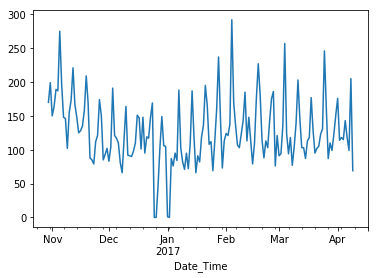

In [14]:
bakery_daily.Item.plot()

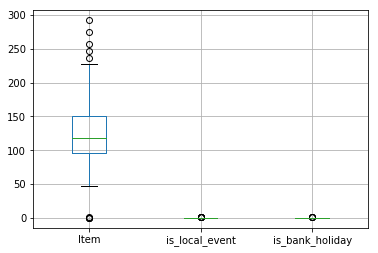

In [15]:
bakery_daily.boxplot()

In [16]:
bakery_daily.describe()

,Item,is_local_event,is_bank_holiday
count,162.000000,162.000000,162.000000
mean,126.580247,0.037037,0.024691
std,47.906188,0.189438,0.155664
min,0.000000,0.000000,0.000000
25%,95.750000,0.000000,0.000000
50%,118.000000,0.000000,0.000000
75%,150.750000,0.000000,0.000000
max,292.000000,1.000000,1.000000


### I have decided to remove the 1 sale of bread on the bank holiday as it was an exception

In [17]:
bakery_daily[bakery_daily['Item'] == 1]

,Item,is_local_event,is_bank_holiday
Date_Time,,,
2017-01-01,1,0,1


In [18]:
bakery_daily.loc[bakery_daily['Item'] == 1, 'Item'] = 0

In [19]:
bakery_daily[bakery_daily['Item'] == 1]

,Item,is_local_event,is_bank_holiday
Date_Time,,,


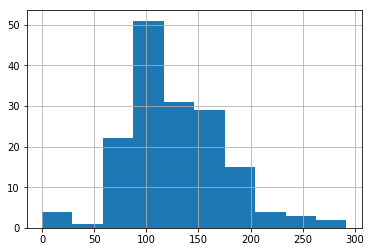

In [20]:
bakery_daily['Item'].hist()

### Daily sales plus trend

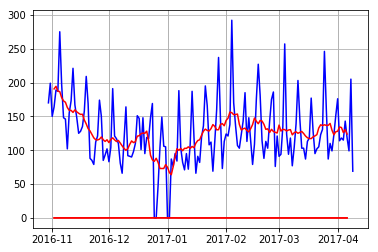

In [21]:
decomposition = sm.tsa.seasonal_decompose(bakery_daily,model="additive")

fig, ax = plt.subplots()
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=1)

year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(month)
ax.xaxis.set_major_formatter(month_format)

plt.plot(bakery_daily.index, bakery_daily['Item'], c='blue')
plt.plot(decomposition.trend.index, decomposition.trend, c='red')

In [22]:
bakery_daily['Date'] = bakery_daily.index

In [23]:
bakery_daily['Week_Day'] = bakery_daily.Date.dt.day_name()

In [24]:
bakery_daily.head(2)

,Item,is_local_event,is_bank_holiday,Date,Week_Day
Date_Time,,,,,
2016-10-30,170,0,0,2016-10-30,Sunday
2016-10-31,199,0,0,2016-10-31,Monday


### Creating a loop dropping different day at a time to see if I get differnt results 

In [25]:
#train-test-split, fitting-model, testing definition
def fit_linear_model(X, y, day, model_inst):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
    result_list = []

    model_inst.fit(X_train, y_train)
    
    y_pred = model_inst.predict(X_train)
    
    MAE = metrics.mean_absolute_error(y_train, y_pred)
    RMSE =np.sqrt(metrics.mean_squared_error(y_train, y_pred))

    result_list= [day, MAE, RMSE, model_inst.intercept_, model_inst, model_inst.coef_]
    return result_list


In [26]:
# list containing the days of the week
days_of_the_week = ['Week_Day_Monday','Week_Day_Tuesday','Week_Day_Wednesday','Week_Day_Thursday','Week_Day_Friday', 'Week_Day_Saturday','Week_Day_Sunday']

In [27]:
#Creating dataframe to save resuls
columns = ['Day','MAE','RMSE','Intercept','Model', 'Coef']

results_dropping_day = pd.DataFrame(index=range(21), columns=columns)
model_list =[LinearRegression(), Ridge(), Lasso()]

for i, model_item in enumerate(model_list):
    if i == 0:
        n = 0
    elif i == 1:
        n = 7
    else:
        n = 14
            
            
    for i, day in enumerate(days_of_the_week):
        bakery_data_for_model_drop = pd.get_dummies(bakery_daily)
        # set y
        y = bakery_data_for_model_drop['Item']
        del bakery_data_for_model_drop[day]
        del bakery_data_for_model_drop['Item']
        del bakery_data_for_model_drop['Date']

        X = bakery_data_for_model_drop

        results_dropping_day.loc[i + n] = fit_linear_model(X, y, day, model_item)


### For Linear regression there is no difference in terms of RMSE to drop any day, it is the interpretacion that will change only

In [28]:
#Linear regression results
results_dropping_day

,Day,MAE,RMSE,Intercept,Model,Coef
0,Week_Day_Monday,21.536,27.9446,113.408,"LinearRegression(copy_X=True, fit_intercept=Tr...","[60.114285714285835, -121.58045977011483, 21.4..."
1,Week_Day_Tuesday,21.536,27.9446,101.444,"LinearRegression(copy_X=True, fit_intercept=Tr...","[60.114285714285785, -121.58045977011497, 33.3..."
2,Week_Day_Wednesday,21.536,27.9446,101.824,"LinearRegression(copy_X=True, fit_intercept=Tr...","[60.114285714285664, -121.58045977011459, 33.0..."
3,Week_Day_Thursday,21.536,27.9446,111.778,"LinearRegression(copy_X=True, fit_intercept=Tr...","[60.11428571428574, -121.58045977011496, 23.05..."
4,Week_Day_Friday,21.536,27.9446,134.833,"LinearRegression(copy_X=True, fit_intercept=Tr...","[60.114285714285856, -121.58045977011496, -21...."
5,Week_Day_Saturday,21.536,27.9446,183.286,"LinearRegression(copy_X=True, fit_intercept=Tr...","[60.11428571428573, -121.58045977011489, -48.4..."
6,Week_Day_Sunday,21.536,27.9446,137.925,"LinearRegression(copy_X=True, fit_intercept=Tr...","[60.11428571428545, -121.58045977011479, -3.09..."
7,Week_Day_Monday,22.0447,28.4258,114.41,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...","[51.08367254479815, -91.01036819749653, 19.348..."
8,Week_Day_Tuesday,21.9474,28.556,108.324,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...","[51.40400809668016, -88.71865396830117, 25.114..."
9,Week_Day_Wednesday,22.3026,28.5546,108.895,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...","[51.37396040527296, -88.74070924020806, 24.573..."


### Adding day of the week as dummies

In [29]:
bakery_data_for_model = pd.get_dummies(bakery_daily)

In [30]:
bakery_data_for_model.head(2)

,Item,is_local_event,is_bank_holiday,Date,Week_Day_Friday,Week_Day_Monday,Week_Day_Saturday,Week_Day_Sunday,Week_Day_Thursday,Week_Day_Tuesday,Week_Day_Wednesday
Date_Time,,,,,,,,,,,
2016-10-30,170,0,0,2016-10-30,0,0,0,1,0,0,0
2016-10-31,199,0,0,2016-10-31,0,1,0,0,0,0,0


### Dropping a day, in this case Wednesday

In [31]:
del bakery_data_for_model['Week_Day_Wednesday']

In [32]:
bakery_data_for_model.head(2)

,Item,is_local_event,is_bank_holiday,Date,Week_Day_Friday,Week_Day_Monday,Week_Day_Saturday,Week_Day_Sunday,Week_Day_Thursday,Week_Day_Tuesday
Date_Time,,,,,,,,,,
2016-10-30,170,0,0,2016-10-30,0,0,0,1,0,0
2016-10-31,199,0,0,2016-10-31,0,1,0,0,0,0


In [33]:
bakery_data_for_model.to_pickle('Data/bakery_data_for_model.pkl')

In [34]:
bakery_data_for_model.columns

Index(['Item', 'is_local_event', 'is_bank_holiday', 'Date', 'Week_Day_Friday',
       'Week_Day_Monday', 'Week_Day_Saturday', 'Week_Day_Sunday',
       'Week_Day_Thursday', 'Week_Day_Tuesday'],
      dtype='object')

In [35]:
bakery_data_for_model['Item'].sort_values(ascending=True).head(5)

Date_Time
2016-12-25     0
2017-01-02     0
2017-01-01     0
2016-12-26     0
2016-12-27    47
Name: Item, dtype: int64

### Train and Test split

In [36]:
X = bakery_data_for_model[['is_local_event','is_bank_holiday','Week_Day_Friday', 'Week_Day_Monday',
       'Week_Day_Saturday', 'Week_Day_Sunday', 'Week_Day_Thursday',
       'Week_Day_Tuesday']]
y = bakery_data_for_model['Item']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

#transform the targe to get a simplier relation, in this case is log(x + 1) becuase there are zeros in data
y_train_log = np.log(y_train + 1)
y_test_log =  np.log(y_test + 1)

print(len(X_train), len(X_test))
print(len(y_train), len(y_test))


129 33
129 33


### Tuning the linear regression

In [37]:
# Setup our GridSearch Parmaters
search_parameters = {
    'fit_intercept':  [True, False], 
    'normalize':      [False, True]
}

# Intialize a blank model object
lm = LinearRegression()

# Initialize gridsearch
estimator = GridSearchCV(
    lm, # estimator
    search_parameters, # hyper-parameter space to search 
    cv=5, # number of folds
    scoring="neg_mean_squared_error", # scoring metric to optimise for
    return_train_score=True,
    iid=True
)

# Fit some data
results = estimator.fit(X_train,y_train)
print (results.best_estimator_)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


In [38]:
testing = pd.DataFrame(results.cv_results_)

In [39]:
testing

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fit_intercept,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003125,0.006251,0.000000,0.000000,True,False,"{'fit_intercept': True, 'normalize': False}",-491.150572,-811.155286,-893.255890,...,-857.804033,224.594045,1,-867.221877,-782.675031,-756.331906,-766.158375,-691.631013,-772.803640,56.421132
1,0.006250,0.007655,0.000000,0.000000,True,True,"{'fit_intercept': True, 'normalize': True}",-491.150572,-811.155286,-893.255890,...,-857.804033,224.594045,2,-867.221877,-782.675031,-756.331906,-766.158375,-691.631013,-772.803640,56.421132
2,0.003125,0.006250,0.003125,0.006251,False,False,"{'fit_intercept': False, 'normalize': False}",-1345.988179,-1428.505714,-3174.953284,...,-2214.465597,771.665870,3,-2362.626407,-2337.691213,-1891.332789,-1940.554193,-2167.699694,-2139.980859,195.461309
3,0.003125,0.006251,0.000000,0.000000,False,True,"{'fit_intercept': False, 'normalize': True}",-1345.988179,-1428.505714,-3174.953284,...,-2214.465597,771.665870,3,-2362.626407,-2337.691213,-1891.332789,-1940.554193,-2167.699694,-2139.980859,195.461309


### Fit the model

In [40]:
lr = LinearRegression(fit_intercept=True, normalize = False)
lr_log = LinearRegression()

#estimation the line
lr.fit(X_train, y_train)
lr_log.fit(X_train, y_train_log)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [41]:
print(lr.intercept_, [z for z in zip(X.columns, lr.coef_)])

101.82352941176472 [('is_local_event', 60.114285714285664), ('is_bank_holiday', -121.58045977011459), ('Week_Day_Friday', 33.00980392156864), ('Week_Day_Monday', 11.584516565246737), ('Week_Day_Saturday', 81.46218487394964), ('Week_Day_Sunday', 36.10175794455708), ('Week_Day_Thursday', 9.954248366013022), ('Week_Day_Tuesday', -0.37908496732032404)]


In [42]:
y_pred = lr.predict(X_train)
y_pred_log = lr_log.predict(X_train)

### Getting the best alpha to use in Ridge

In [43]:
grid = GridSearchCV(estimator=Ridge(),
                    param_grid={'alpha': np.logspace(-10,10, 20)},
                    scoring='neg_mean_squared_error',
                    return_train_score=True,
                    cv=5, 
                   iid=True)

grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.00000e-10, 1.12884e-09, 1.27427e-08, 1.43845e-07, 1.62378e-06,
       1.83298e-05, 2.06914e-04, 2.33572e-03, 2.63665e-02, 2.97635e-01,
       3.35982e+00, 3.79269e+01, 4.28133e+02, 4.83293e+03, 5.45559e+04,
       6.15848e+05, 6.95193e+06, 7.84760e+07, 8.85867e+08, 1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [44]:
print(np.sqrt(-grid.best_score_), grid.best_params_)

best_model = grid.best_estimator_
np.sqrt(mean_squared_error(y_test, best_model.predict(X_test)))

29.288291747196283 {'alpha': 1e-10}


24.043677987737325

In [45]:
#really small alpha
grid.best_params_

{'alpha': 1e-10}

In [46]:
ridge = Ridge(alpha=1e-10, normalize=False)
ridge.fit(X_train, y_train)

print(lr.coef_, np.sqrt(mean_squared_error(y_train, lr.predict(X_train))), "\n")
print(ridge.coef_, np.sqrt(mean_squared_error(y_train, ridge.predict(X_train))))

[  60.11428571 -121.58045977   33.00980392   11.58451657   81.46218487
   36.10175794    9.95424837   -0.37908497] 27.944573751779 

[  60.11428571 -121.58045977   33.00980392   11.58451656   81.46218487
   36.10175794    9.95424836   -0.37908497] 27.944573751779


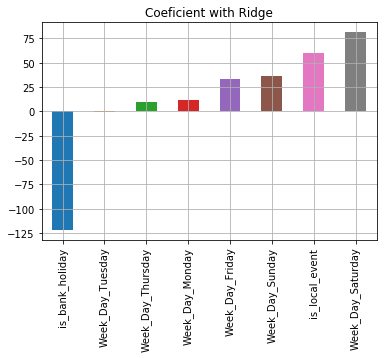

In [47]:
predictors = X_train.columns

coefRidge = Series(ridge.coef_,predictors).sort_values()

coefRidge.plot(kind='bar', title='Coeficient with Ridge', grid=True)

### fiting a lasso

In [48]:
lasso = Lasso(normalize=False)

lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

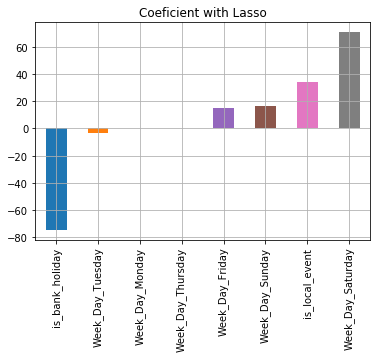

In [49]:
predictors = X_train.columns

coefLasso = Series(lasso.coef_,predictors).sort_values()

coefLasso.plot(kind='bar', title='Coeficient with Lasso', grid=True)

### Get the RMSE and scores for all models

In [50]:
#Get the RMSE and score of all models in a dataframe
RMSE_SCORES_results = pd.DataFrame(columns=['Model', 'Train_RMSE', 'Test_RMSE', 'Train_Score','Test_Score'], index=range(3))
model_list = [lr,ridge,lasso]
y_pred_mean_train = [y_train.mean()] * len(y_train)
y_pred_mean_test = [y_test.mean()] * len(y_test)

for i, item in enumerate(model_list):
    rmse_train = np.sqrt(mean_squared_error(y_train, item.predict(X_train)))
    rmse_test = np.sqrt(mean_squared_error(y_test, item.predict(X_test)))
    score_train = item.score(X_train, y_train)
    score_test = item.score(X_test, y_test)
    item_str = str(item)
    RMSE_SCORES_results.loc[i] = [item_str[:6], rmse_train, rmse_test, score_train,score_test]

RMSE_SCORES_results.loc[3] = ['Baseline',  np.sqrt(metrics.mean_squared_error(y_train, y_pred_mean_train)), np.sqrt(metrics.mean_squared_error(y_test, y_pred_mean_test)),0.0, 0.0]

RMSE_SCORES_results.index = RMSE_SCORES_results.Model

In [51]:
RMSE_SCORES_results

,Model,Train_RMSE,Test_RMSE,Train_Score,Test_Score
Model,,,,,
Linear,Linear,27.9446,24.0437,0.658351,0.7452
Ridge(,Ridge(,27.9446,24.0437,0.658351,0.7452
Lasso(,Lasso(,29.8488,28.5961,0.610204,0.639576
Baseline,Baseline,47.8088,47.6322,0,0


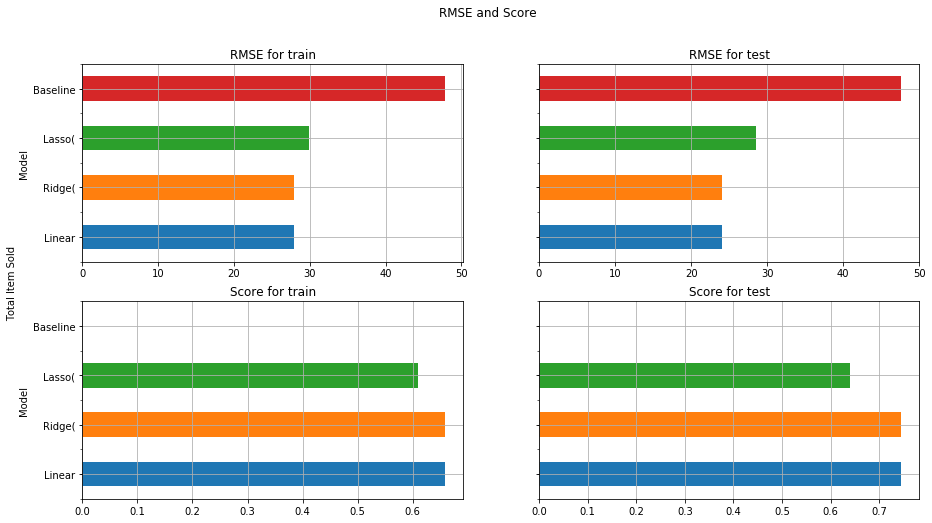

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(15,8), sharex=False, sharey=True, squeeze=False)

fig.suptitle('RMSE and Score', fontsize=12)
fig.text(0.06, 0.5, 'Total Item Sold', ha='center', va='center', rotation='vertical')
#fig.text(0.5, 0.04, 'Hours', ha='center', va='center')
RMSE_train_graph = RMSE_SCORES_results['Train_RMSE']
RMSE_train_graph.plot(ax=axes[0][0], grid=True, kind='barh', title='RMSE for train')

RMSE_test_graph = RMSE_SCORES_results['Test_RMSE']
RMSE_test_graph.plot(ax=axes[0][1], grid=True, kind='barh', title='RMSE for test')

score_train_graph = RMSE_SCORES_results['Train_Score']
score_train_graph.plot(ax=axes[1][0], grid=True, kind='barh', title='Score for train')

score_test_graph = RMSE_SCORES_results['Test_Score']
score_test_graph.plot(ax=axes[1][1], grid=True, kind='barh', title='Score for test')

#plt.xticks(rotation=45)
#RMSE_SCORES_results['Train_RMSE'].plot(kind='bar')

### Let's run cross validation on all models

- All models have a little of a variance problem

In [53]:
def cross_validation_test(model_name, x_data, y_data, scoring_name, n):
    cv_scores = cross_val_score(model_name, x_data, y_data, scoring=scoring_name, cv=n)
    return np.sqrt(-cv_scores), np.sqrt(-cv_scores.mean())

In [68]:
RMSE_SCORES_results = pd.DataFrame(columns=['Model', 'RMSE', 'Average RMSE'], index=range(2))
model_list = [lr,ridge,lasso]
print('Training set')            
for item in model_list:
    model_string = str(item)
    print('Results for ' + model_string[:10])
    print(cross_validation_test(item,  X, y, 'neg_mean_squared_error', 5))
                                            

Training set
Results for LinearRegr
(array([39.59427891, 54.50391573, 26.81688843, 22.51864725, 25.02456108]), 35.75149616136107)
Results for Ridge(alph
(array([39.59427891, 54.50391573, 26.81688843, 22.51864725, 25.02456108]), 35.75149616133811)
Results for Lasso(alph
(array([41.63633919, 53.85217082, 30.42497134, 25.91261097, 23.34773934]), 36.8127702416697)


In [56]:
results_pred_train = pd.DataFrame({'Actual': y_train, 'LR_Pred': lr.predict(X_train), 'LR_log_Pred': np.exp(lr_log.predict(X_train))-1, 'Lasso_Pred': lasso.predict(X_train), 'Ridge_Pred': ridge.predict(X_train)}) 

In [57]:
results_pred_train.describe()

,Actual,LR_Pred,LR_log_Pred,Lasso_Pred,Ridge_Pred
count,129.000000,129.000000,129.000000,129.000000,129.000000
mean,126.379845,126.379845,123.265221,126.379845,126.379845
std,47.995148,38.942705,38.874134,31.164718,38.942705
min,0.000000,-8.172414,-0.062910,37.536583,-8.172414
25%,95.000000,101.823529,99.215595,112.281888,101.823529
50%,117.000000,113.408046,109.334294,112.281888,113.408046
75%,151.000000,137.925287,133.080854,128.670728,137.925287
max,275.000000,243.400000,242.600802,217.601309,243.400000


### Comparing results

We are getting negative sales for the bank holiday, not perfect models but in here it does not matter as we  know that that is not possible and at the same time is doing a good job predicting the rest. 

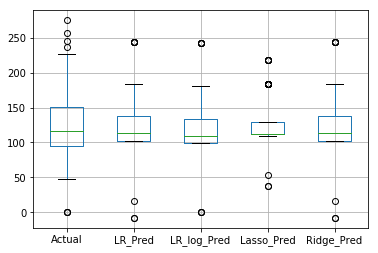

In [58]:
results_pred_train.boxplot()

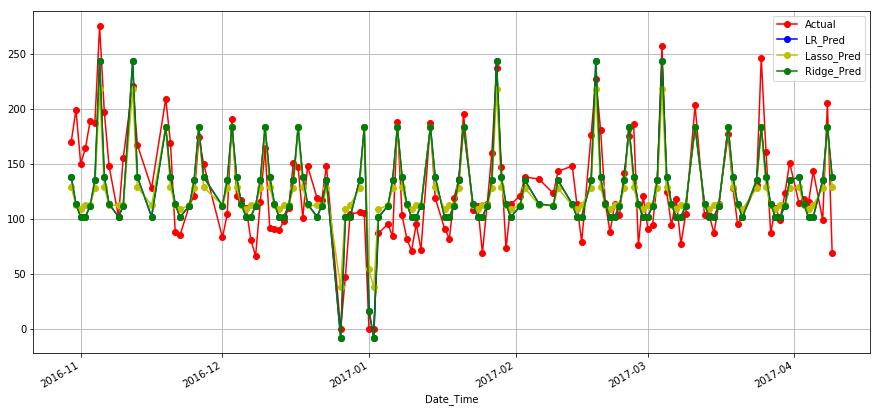

In [59]:
results_pred_train[['Actual', 'LR_Pred', 'Lasso_Pred', 'Ridge_Pred']].plot(figsize=(15,7), style={'Actual': '-or', 'LR_Pred': '-ob', 'Lasso_Pred': '-oy', 'Ridge_Pred': '-og'}, grid=True)

In [60]:
results_pred_test = pd.DataFrame({'Actual': y_test, 'LR_Pred': lr.predict(X_test),'LR_log_Pred': np.exp(lr_log.predict(X_test))-1,'Lasso_Pred': lasso.predict(X_test), 'Ridge_Pred': ridge.predict(X_test)})  

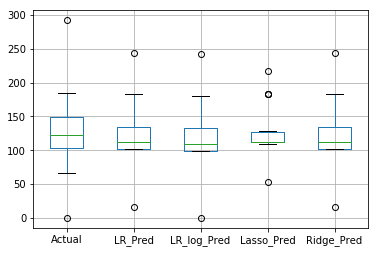

In [61]:
results_pred_test.boxplot()

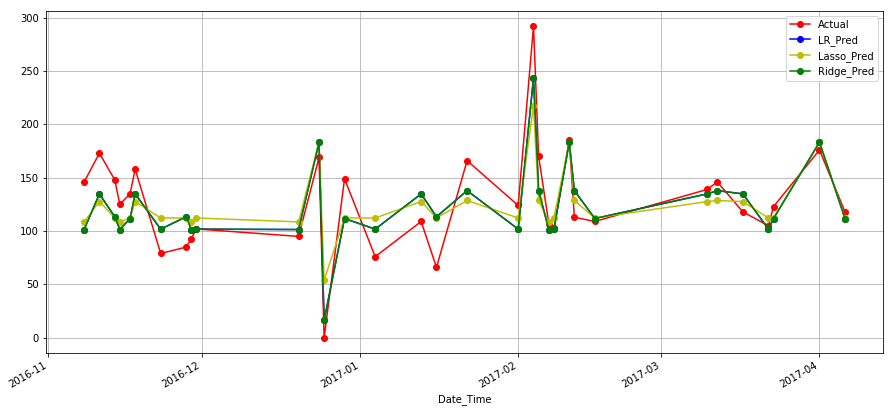

In [62]:
results_pred_test[['Actual', 'LR_Pred', 'Lasso_Pred', 'Ridge_Pred']].plot(figsize=(15,7), style={'Actual': '-or', 'LR_Pred': '-ob', 'Lasso_Pred': '-oy', 'Ridge_Pred': '-og'}, grid=True)

In [63]:
results_pred_test.sort_index()

,Actual,LR_Pred,LR_log_Pred,Lasso_Pred,Ridge_Pred
Date_Time,,,,,
2016-11-08,146,101.444444,98.776649,108.611111,101.444444
2016-11-11,173,134.833333,132.253018,127.666196,134.833333
2016-11-14,148,113.408046,109.334294,112.281888,113.408046
2016-11-15,125,101.444444,98.776649,108.611111,101.444444
2016-11-17,135,111.777778,108.651329,112.281888,111.777778
2016-11-18,158,134.833333,132.253018,127.666196,134.833333
2016-11-23,79,101.823529,99.215595,112.281888,101.823529
2016-11-28,85,113.408046,109.334294,112.281888,113.408046
2016-11-29,93,101.444444,98.776649,108.611111,101.444444


In [64]:
results_pred_test.describe()

,Actual,LR_Pred,LR_log_Pred,Lasso_Pred,Ridge_Pred
count,33.000000,33.000000,33.000000,33.000000,33.000000
mean,127.333333,122.810491,119.320572,123.921141,122.810491
std,48.370747,37.200543,38.545770,29.302592,37.200543
min,0.000000,16.344828,0.138774,53.925423,16.344828
25%,103.000000,101.823529,99.215595,112.281888,101.823529
50%,123.000000,111.777778,108.651329,112.281888,111.777778
75%,149.000000,134.833333,132.253018,127.666196,134.833333
max,292.000000,243.400000,242.600802,217.601309,243.400000


In [65]:
results_pred_test.sort_index().head(2)

,Actual,LR_Pred,LR_log_Pred,Lasso_Pred,Ridge_Pred
Date_Time,,,,,
2016-11-08,146,101.444444,98.776649,108.611111,101.444444
2016-11-11,173,134.833333,132.253018,127.666196,134.833333


In [66]:
results_pred_test.to_pickle('Data/results_pred_test.pkl')

In [67]:
results_pred_train.to_pickle('Data/results_pred_train.pkl')

### Conclusion
For the purpose of predicting daily sales from a bakery the best model to use and the simplest is Linear Regression, it is not perfect specially when the sales are really high, but because we know that we could make adjustments. 
- Bank holiday sales are not negative there are zero
- The model underestimates sales for local events
- For the rest the models makes good predictions